Tutorial tirado de https://towardsdatascience.com/deep-clustering-for-financial-market-segmentation-2a41573618cf

In [84]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/README.md
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/ae_weights.h5
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/autoencoder.png
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/._CC GENERAL.csv.xls
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/model.png
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/encoder.png
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/DEC_model_final.h5
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/._README.md
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/._notebook1f4eb255d2.ipynb
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/install.sh
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/CC GENERAL.csv.xls
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/notebook1f4eb255d2.ipynb
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/requirements.txt
/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/.ipynb_checkpoints/notebook1f4eb255d2-checkpoint.ipynb


In [85]:
from time import time
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [86]:
# Data preparation
data = pd.read_csv('/prj/nowage/work-AiNeis/AiNeis/models/DCforFMS/CC GENERAL.csv.xls')
data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [87]:
# Selecting features
# O campo cust_id é unico e não serve para clusterização, por isso é descartado
data_x = data.drop(['CUST_ID'], axis=1)

In [88]:
# Re-escala tudo para o intervalo entre 0 e 1
# Pois o kmeans é sensitivo para a escala de valores das features, já que usa distância euclidiana como métrica de similaridade
from sklearn.preprocessing import MinMaxScaler
numeric_columns = data_x.columns.values.tolist()
scaler = MinMaxScaler()
data_x[numeric_columns] = scaler.fit_transform(data_x[numeric_columns])
data_x.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,NaN,0.000000,1.0
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0


In [89]:
# Lidando com dados faltando
data_x.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [90]:
# Completando os dados que faltam com zero
data_x.fillna(0, inplace=True)

# Implementation of the DEC Method in Keras

-   Step 1: Estimating the number of clusters
-   Step 2: Creating and training a K-means model
-   Step 3: Creating and training an autoencoder
-   Step 4: Implementing DEC Soft Labeling
-   Step 5: Creating a new DEC model
-   Step 6: Training the New DEC Model
-   Step 7: Using the Trained DEC Model for Predicting Clustering Classes
-   Step 8: Jointly Refining DEC Model
-   Step 9: Using Refined DEC Model for Predicting Clustering Classes
-   Step 10: Comparing with K-means


In [91]:
# Creating and training autoencoder
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected symmetric auto-encoder model.
  
    dims: list of the sizes of layers of encoder like [500, 500, 2000, 10]. 
          dims[0] is input dim, dims[-1] is size of the latent hidden layer.

    act: activation function
    
    return:
        (autoencoder_model, encoder_model): Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers of encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # latent hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)

    x = encoded
    # internal layers of decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # decoder output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    
    decoded = x
    
    autoencoder_model = Model(inputs=input_data, outputs=decoded, name='autoencoder')
    encoder_model     = Model(inputs=input_data, outputs=encoded, name='encoder')
    
    return autoencoder_model, encoder_model


In [92]:
data_x.dtypes

BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                    float64
PURCHASES_TRX                       float64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                              float64
dtype: object

In [93]:
x = data_x.values
x.shape

(8950, 17)

In [94]:
# Estimating the number of clusters
# Para treinar o kmeans é necessário ter o numero de clusters
# O número de clusters é estimado explorando os valores de silhouette de diferentes execuções de k-means

# um valor de silhouette mede o quão similar um dado é dentro do seu cluster, comparado com os outros clusters
# o valor vai de -1  a +1 
# onde um valor alto indica que o dado bate com seu próprio cluster, caso seja baixo, é pq bate mais com os clusters vizinhos 

for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters,n_init=10) #, n_jobs=4)
    preds = clusterer.fit_predict(x)
    score = silhouette_score(x, preds, metric='euclidean')
    print('For n_clusters = {}, Kmeans silhouette score is {}'.format(num_clusters, score))
    

For n_clusters = 2, Kmeans silhouette score is 0.3867399802746641
For n_clusters = 3, Kmeans silhouette score is 0.372350277731719
For n_clusters = 4, Kmeans silhouette score is 0.3215104946972683
For n_clusters = 5, Kmeans silhouette score is 0.3191245036049048
For n_clusters = 6, Kmeans silhouette score is 0.33425848697248306
For n_clusters = 7, Kmeans silhouette score is 0.3374010479754178
For n_clusters = 8, Kmeans silhouette score is 0.32449217790300583
For n_clusters = 9, Kmeans silhouette score is 0.3340553328894084


In [95]:
n_clusters = 3 
n_epochs   = 100
batch_size = 128

In [96]:
# Creating and Training K-means model
kmeans = KMeans(n_clusters=n_clusters,n_init=10) #, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x) #x == valores do csv

In [97]:

# Tamanho das camadas
# configuração generica do autoencoder da rede neural de qualquer dataset
dims = [x.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1./3., mode='fan_in', distribution='uniform')
pretrain_optimizer = SGD(learning_rate=1, momentum=0.9)
pretrain_epochs = n_epochs
batch_size = batch_size
save_dir='/kaggle/output'

In [98]:
dims

[17, 500, 500, 2000, 10]

In [99]:
init

In [100]:
# Criação do modelo de autoencoder

autoencoder, encoder = autoencoder(dims, init=init)

/prj/nowage/.virtualenvs/AiNeis/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [101]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [102]:
#!pip install pydot

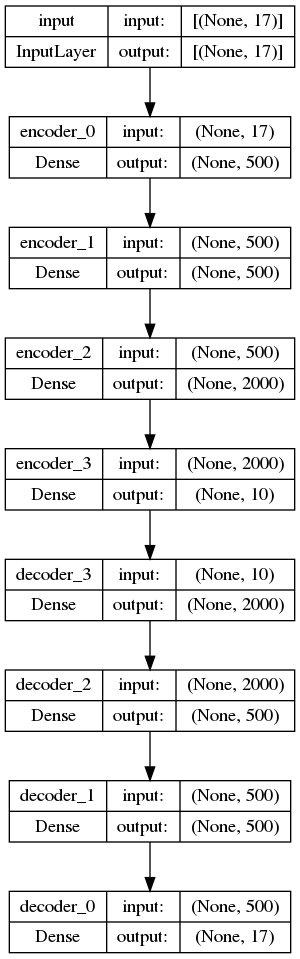

In [103]:
plot_model(autoencoder, to_file='encoder.png', show_shapes=True)
Image(filename='encoder.png')

In [104]:
# Treinamento do autoencoder
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x,x, batch_size=batch_size, epochs=pretrain_epochs)
autoencoder.save_weights('ae_weights.h5')

Epoch 1/100
70/70 [==============================] - 1s 3ms/step - loss: 0.0352
Epoch 2/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 3/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0058
Epoch 4/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 5/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 6/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 7/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 8/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0013
Epoch 9/100
70/70 [==============================] - 0s 3ms/step - loss: 0.0010
Epoch 10/100
70/70 [==============================] - 0s 3ms/step - loss: 9.1644e-04
Epoch 11/100
70/70 [==============================] - 0s 3ms/step - loss: 8.2789e-04
Epoch 12/100
70/70 [==============================] - 0s 3ms/step - loss: 7.8658e-04
Epoch 13/100
70/70 [=====

In [105]:
autoencoder.load_weights('ae_weights.h5')

In [106]:
'''
Um dos componentes chaves de DEC é o soft labeling, que é a atribuição a uma classe estimada para cada dado, 
de forma que possa ser refinado iterativamente
'''
class ClusteringLayer(Layer):
    '''
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    '''

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name='clusters', shape=(self.n_clusters, input_dim), initializer='glorot_uniform') 
        
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ''' 
        student t-distribution, as used in t-SNE algorithm.
        It measures the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
       
        inputs: the variable containing data, shape=(n_samples, n_features)
        
        Return: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        '''
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure all of the values of each sample sum up to 1.
        
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [107]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

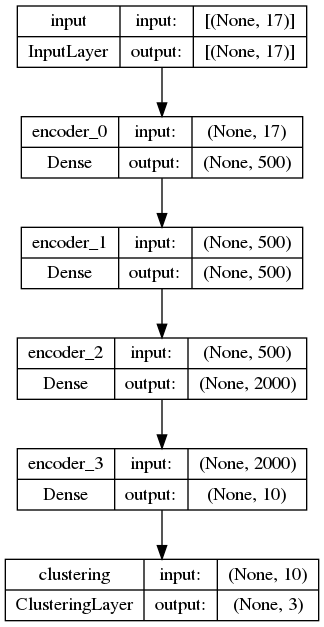

In [108]:
plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')

In [109]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')


In [110]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))

280/280 [==============================] - 0s 715us/step


In [111]:
y_pred_last = np.copy(y_pred)

In [112]:
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

**DEEP CLUSTERING**

In [113]:
#Training the new DEC model
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T



In [114]:
loss = 0
index = 0
maxiter = 1000
update_interval = 100
index_array = np.arange(x.shape[0])

In [115]:
tol = 0.001

In [116]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)
    
    idx = index_array[index*batch_size : min((index+1)*batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0
    print ('ite: {}'.format(str(ite)))
    
model.save_weights('DEC_model_final.h5')

ite: 0
ite: 1
ite: 2
ite: 3
ite: 4
ite: 5
ite: 6
ite: 7
ite: 8
ite: 9
ite: 10
ite: 11
ite: 12
ite: 13
ite: 14
ite: 15
ite: 16
ite: 17
ite: 18
ite: 19
ite: 20
ite: 21
ite: 22
ite: 23
ite: 24
ite: 25
ite: 26
ite: 27
ite: 28
ite: 29
ite: 30
ite: 31
ite: 32
ite: 33
ite: 34
ite: 35
ite: 36
ite: 37
ite: 38
ite: 39
ite: 40
ite: 41
ite: 42
ite: 43
ite: 44
ite: 45
ite: 46
ite: 47
ite: 48
ite: 49
ite: 50
ite: 51
ite: 52
ite: 53
ite: 54
ite: 55
ite: 56
ite: 57
ite: 58
ite: 59
ite: 60
ite: 61
ite: 62
ite: 63
ite: 64
ite: 65
ite: 66
ite: 67
ite: 68
ite: 69
ite: 70
ite: 71
ite: 72
ite: 73
ite: 74
ite: 75
ite: 76
ite: 77
ite: 78
ite: 79
ite: 80
ite: 81
ite: 82
ite: 83
ite: 84
ite: 85
ite: 86
ite: 87
ite: 88
ite: 89
ite: 90
ite: 91
ite: 92
ite: 93
ite: 94
ite: 95
ite: 96
ite: 97
ite: 98
ite: 99
ite: 100
ite: 101
ite: 102
ite: 103
ite: 104
ite: 105
ite: 106
ite: 107
ite: 108
ite: 109
ite: 110
ite: 111
ite: 112
ite: 113
ite: 114
ite: 115
ite: 116
ite: 117
ite: 118
ite: 119
ite: 120
ite: 121
ite: 122
ite

In [117]:
model.load_weights('DEC_model_final.h5')

In [118]:
#  Using Trained DEC Model for Predicting Clustering Classes
q = model.predict(x, verbose=0)
p = target_distribution(q)

y_pred = q.argmax(1)

In [119]:
data_all = data_x.copy()

In [120]:
data_all

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.002148,0.818182,0.001945,0.000000,0.004240,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0
1,0.168169,0.909091,0.000000,0.000000,0.000000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0
2,0.131026,1.000000,0.015766,0.018968,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0
3,0.087521,0.636364,0.030567,0.036775,0.000000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,0.000000,0.000000,1.0
4,0.042940,1.000000,0.000326,0.000393,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8945,0.001496,1.000000,0.005936,0.000000,0.012939,0.000000,1.000000,0.000000,0.833333,0.000000,0.00000,0.016760,0.031720,0.006419,0.000640,0.500000,0.0
8946,0.001007,1.000000,0.006118,0.000000,0.013333,0.000000,1.000000,0.000000,0.833333,0.000000,0.00000,0.016760,0.031720,0.005439,0.000000,0.000000,0.0
8947,0.001229,0.833333,0.002945,0.000000,0.006418,0.000000,0.833333,0.000000,0.666667,0.000000,0.00000,0.013966,0.031720,0.001602,0.001078,0.250000,0.0
8948,0.000707,0.833333,0.000000,0.000000,0.000000,0.000776,0.000000,0.000000,0.000000,0.111111,0.01626,0.000000,0.015025,0.001036,0.000729,0.250000,0.0


In [121]:
data_all['cluster'] = y_pred

In [122]:
data_all.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,0.002148,0.818182,0.001945,0.000000,0.00424,0.000000,0.166667,0.000000,0.083333,0.000000,0.00000,0.005587,0.031720,0.003979,0.001826,0.000000,1.0,1
1,0.168169,0.909091,0.000000,0.000000,0.00000,0.136685,0.000000,0.000000,0.000000,0.166667,0.03252,0.000000,0.232053,0.080893,0.014034,0.222222,1.0,1
2,0.131026,1.000000,0.015766,0.018968,0.00000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.033520,0.248748,0.012264,0.008210,0.000000,1.0,0
3,0.087521,0.636364,0.030567,0.036775,0.00000,0.004366,0.083333,0.083333,0.000000,0.055555,0.00813,0.002793,0.248748,0.000000,0.000000,0.000000,1.0,1
4,0.042940,1.000000,0.000326,0.000393,0.00000,0.000000,0.083333,0.083333,0.000000,0.000000,0.00000,0.002793,0.038397,0.013374,0.003204,0.000000,1.0,1


In [123]:
data_all['cluster'].value_counts()

1    4174
0    3078
2    1698
Name: cluster, dtype: int64

In [124]:
x_embedded = TSNE(n_components=2).fit_transform(x)
x_embedded.shape

(8950, 2)

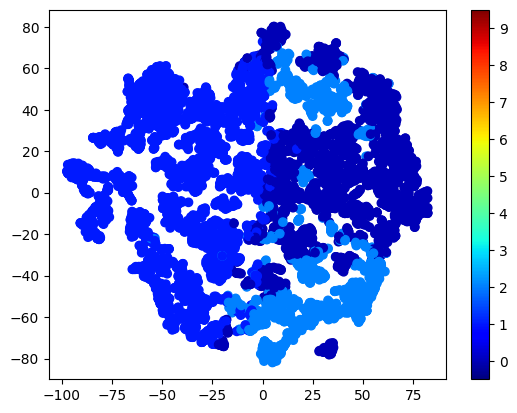

In [125]:
vis_x = x_embedded[:, 0]
vis_y = x_embedded[:, 1]
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

In [126]:
y_pred_kmeans.shape

(8950,)

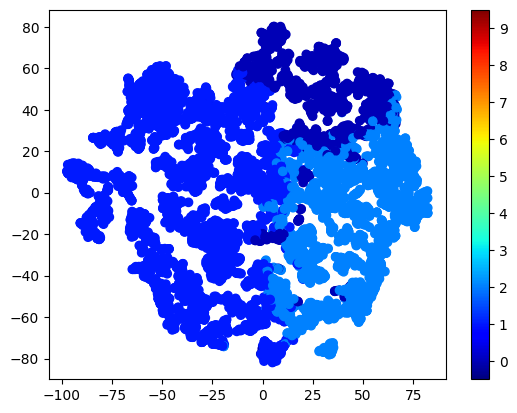

In [127]:
plt.scatter(vis_x, vis_y, c=y_pred_kmeans, cmap=plt.cm.get_cmap('jet', 256))
plt.colorbar(ticks=range(100))
plt.clim(-0.5, 9.5)
plt.show()

In [128]:
score = silhouette_score(x, y_pred_kmeans, metric='euclidean')
print ("For n_clusters = {}, Kmeans silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Kmeans silhouette score is 0.3724165697113531)


In [129]:
score = silhouette_score (x, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

For n_clusters = 3, Deep clustering silhouette score is 0.33200851364237743)


In [130]:
for num_clusters in range(2,10):
    clusterer = KMeans(n_clusters=num_clusters,n_init=10) #, n_jobs=4)
    preds = clusterer.fit_predict(x)
    # centers = clusterer.cluster_centers_
    score = silhouette_score (x, preds, metric='euclidean')
    print ("For n_clusters = {}, Kmeans silhouette score is {})".format(num_clusters, score))

For n_clusters = 2, Kmeans silhouette score is 0.3867190566170049)
For n_clusters = 3, Kmeans silhouette score is 0.3724165697113531)
For n_clusters = 4, Kmeans silhouette score is 0.3215104946972683)
For n_clusters = 5, Kmeans silhouette score is 0.3191245036049048)
For n_clusters = 6, Kmeans silhouette score is 0.3341952374305726)
For n_clusters = 7, Kmeans silhouette score is 0.3373987552503264)
For n_clusters = 8, Kmeans silhouette score is 0.3218123968982665)
For n_clusters = 9, Kmeans silhouette score is 0.3340553328894084)


In [131]:
# Need to re-run autoencoder function declaration!!!
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_data = Input(shape=(dims[0],), name='input')
    x = input_data
    
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_data, outputs=decoded, name='AE'), Model(inputs=input_data, outputs=encoded, name='encoder')

In [132]:
autoencoder, encoder = autoencoder(dims, init=init)


/prj/nowage/.virtualenvs/AiNeis/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer VarianceScaling is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [133]:
# Jointly Refining DEC Model
'''
 ideia principal é aprender simultaneamente a representação da feature e 
 fazer as atribuições do cluster usando DNN. 
 
 Esse código usa o autoencoder pre-treinado e o modelo de kmeans para definir um novo 
 modelo que pega o dataset pre-processado como input e dá como output as classes de clsuterização da predição 
'''
autoencoder.load_weights('ae_weights.h5')
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

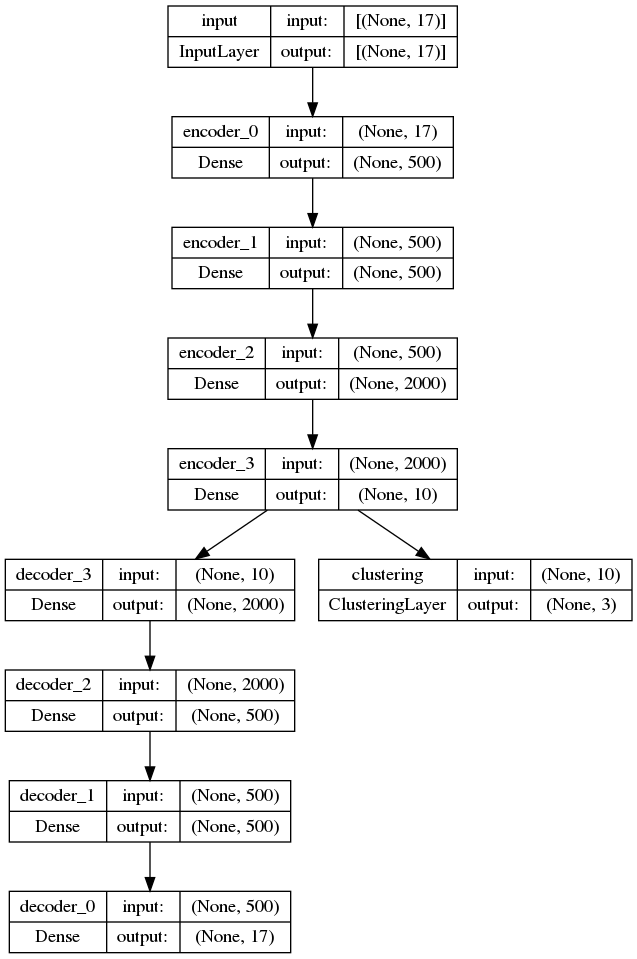

In [134]:

plot_model(model, to_file='model.png', show_shapes=True)
Image(filename='model.png')



In [135]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

280/280 [==============================] - 0s 740us/step


In [136]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer=pretrain_optimizer)

In [137]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights('b_DEC_model_final.h5')

StagingError: in user code:

    File "/prj/nowage/.virtualenvs/AiNeis/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/prj/nowage/.virtualenvs/AiNeis/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 208, in _update_step_xla  *
        return self._update_step(gradient, variable)
    File "/prj/nowage/.virtualenvs/AiNeis/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 216, in _update_step  **
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable encoder_0/kernel:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.{self.__class__.__name__}.'


In [ ]:
model.load_weights('b_DEC_model_final.h5')

In [ ]:
# evaluation of model prediction
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)

# evaluate the clustering performance
y_pred = q.argmax(1)

In [ ]:
score = silhouette_score(x, y_pred, metric='euclidean')
print ("For n_clusters = {}, Deep clustering silhouette score is {})".format(n_clusters, score))

In [ ]:
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

In [ ]:


plt.scatter(vis_x, vis_y, c=y_pred_kmeans, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()



In [ ]:
data_all['cluster'] = y_pred

In [ ]:
data_all['cluster'].value_counts()

In [ ]:
data_cluster_0 = data_all[data_all['cluster'] == 0]

In [ ]:
data_cluster_0.describe()

In [ ]:


data_cluster_1 = data_all[data_all['cluster'] == 1]
data_cluster_1.describe()



In [ ]:
data_cluster_2 = data_all[data_all['cluster'] == 2]
data_cluster_2.describe()

In [ ]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

x_pca.shape

In [ ]:


vis_x = x_pca[:, 0]
vis_y = x_pca[:, 1]
plt.scatter(vis_x, vis_y, c=y_pred, cmap=plt.cm.get_cmap("jet", 256))
plt.colorbar(ticks=range(256))
plt.clim(-0.5, 9.5)
plt.show()

